### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>307 identities</b>. (train: 4,263 / test: 1,215)
* <b>Original dataset</b>: [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 -O CelebA_HQ_facial_identity_dataset.zip
!unzip CelebA_HQ_facial_identity_dataset.zip -d ./CelebA_HQ_facial_identity_dataset

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [3]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './CelebA_HQ_facial_identity_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

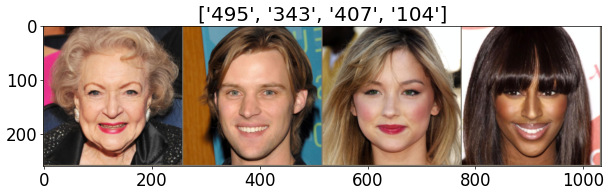

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [5]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### <b>Training Phase</b>


In [6]:
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 5.1119 Acc: 6.8262% Time: 75.8105s
[Test #0] Loss: 3.9629 Acc: 14.0741% Time: 96.7258s
[Train #1] Loss: 2.8186 Acc: 34.3186% Time: 171.6439s
[Test #1] Loss: 2.9449 Acc: 31.6872% Time: 192.3876s
[Train #2] Loss: 1.5589 Acc: 60.3331% Time: 267.9645s
[Test #2] Loss: 1.7018 Acc: 58.0247% Time: 288.6720s
[Train #3] Loss: 0.8629 Acc: 77.6683% Time: 363.8224s
[Test #3] Loss: 1.5255 Acc: 62.3868% Time: 384.3786s
[Train #4] Loss: 0.4417 Acc: 89.6786% Time: 459.2697s
[Test #4] Loss: 1.2191 Acc: 69.7942% Time: 479.7461s
[Train #5] Loss: 0.2112 Acc: 95.9653% Time: 554.5502s
[Test #5] Loss: 0.8667 Acc: 80.0823% Time: 575.0547s
[Train #6] Loss: 0.1061 Acc: 98.3110% Time: 649.7919s
[Test #6] Loss: 0.7654 Acc: 83.0453% Time: 670.3993s
[Train #7] Loss: 0.0415 Acc: 99.6012% Time: 744.9662s
[Test #7] Loss: 0.7018 Acc: 83.5391% Time: 765.5606s
[Train #8] Loss: 0.0321 Acc: 99.7185% Time: 840.0395s
[Test #8] Loss: 0.5614 Acc: 87.5720% Time: 860.6245s
[Train #9] Loss: 0.0307 Acc: 99.6716% Ti

### <b>Final Test Phase</b>

* Save the trained model file.

In [7]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [8]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* Evaluate the trained model.

[Original Image Examples]


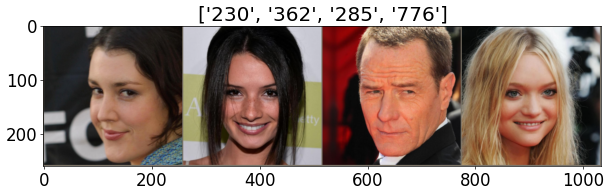

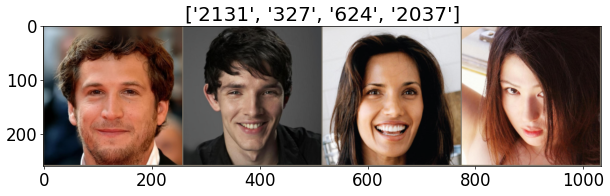

[Prediction Result Examples]


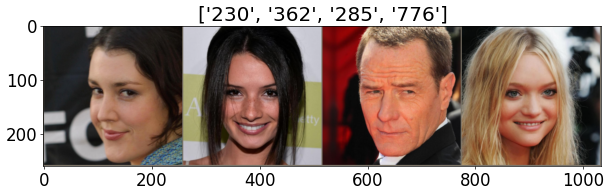

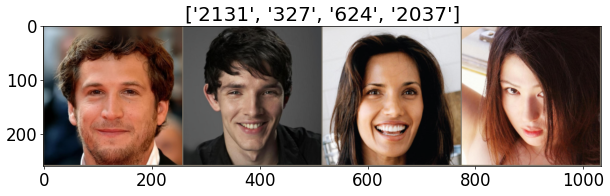

[Test #29] Loss: 0.5039 Acc: 89.0535% Time: 21.9254s


In [9]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))